In [1]:
import os, time
import tensorflow as tf
import numpy as np
from mlp.data_providers import CIFAR10DataProvider, CIFAR100DataProvider
from run import *
#from layers import *
import matplotlib.pyplot as plt
%matplotlib inline
import re

batch_size = 50

In [2]:
train_data = CIFAR10DataProvider('train', batch_size=batch_size)
valid_data = CIFAR10DataProvider('valid', batch_size=batch_size)
#test_data = CIFAR10DataProvider('test', batch_size=50)

In [11]:
a = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
a

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12],
       [13, 14, 15, 16]])

In [16]:
b = np.array([[[1,2,3],[1,2,3],[1,2,3]],[[1,2,3],[1,2,3],[1,2,3]],[[1,2,3],[1,2,3],[1,2,3]]])

In [17]:
b

array([[[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]],

       [[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]],

       [[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]]])

In [21]:
b[0]

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])

In [124]:
sums=[0,0,0]
iters=0
for i in inputs:
    for j in i:
        for k in j:
            sums+=k
            iters+=1
print sums/iters

[ 0.49188264  0.48294163  0.44731991]


In [ ]:
a[1:3,1:3]

In [55]:
data_path = os.path.join(
            os.environ['MLP_DATA_DIR'], 'cifar-10-{0}.npz'.format('train'))

# load data from compressed numpy file
loaded = np.load(data_path)
inputs, targets = loaded['inputs'], loaded['targets']
# Reshaping inputs to 32x32x3
step_one = np.reshape(inputs, (inputs.shape[0],1024,3), order='F')
inputs = np.reshape(step_one, (inputs.shape[0],32,32,3))

In [4]:
new_inputs = inputs[:,5:29,5:29,:]

In [116]:
image=inputs[3].astype(np.float)

In [117]:
sums=[0,0,0]
iters=0
for j in image:
    for k in j:
        sums+=k
        iters+=1
means=sums/iters

In [118]:
image=inputs[3].astype(np.float) - means

In [120]:
std = np.sqrt(np.mean(abs(image)**2))
image=image/float(std)

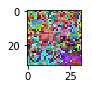

In [121]:
plt.figure(figsize=(1,1))
plt.imshow(image)

In [7]:
image=new_inputs[0].astype(np.float)

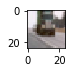

In [8]:
plt.figure(figsize=(0.7,0.7))
plt.imshow(image)

In [3]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    '''Create a fully connected layer with ReLu as the activation function'''
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

def _activation_summary(x):
  """Helper to create summaries for activations.
  Creates a summary that provides a histogram of activations.
  Creates a summary that measure the sparsity of activations.
  Args:
    x: Tensor
  Returns:
    nothing
  """
  # Remove 'tower_[0-9]/' from the name in case this is a multi-GPU training
  # session. This helps the clarity of presentation on tensorboard.
  tensor_name = re.sub('%s_[0-9]*/' % TOWER_NAME, '', x.op.name)
  tf.histogram_summary(tensor_name + '/activations', x)
  tf.scalar_summary(tensor_name + '/sparsity', tf.nn.zero_fraction(x))


def _variable_on_cpu(name, shape, initializer):
  """Helper to create a Variable stored on CPU memory.
  Args:
    name: name of the variable
    shape: list of ints
    initializer: initializer for Variable
  Returns:
    Variable Tensor
  """
  with tf.device('/cpu:0'):
    var = tf.get_variable(name, shape, initializer=initializer)
  return var


def _variable_with_weight_decay(name, shape, stddev, wd):
  """Helper to create an initialized Variable with weight decay.
  Note that the Variable is initialized with a truncated normal distribution.
  A weight decay is added only if one is specified.
  Args:
    name: name of the variable
    shape: list of ints
    stddev: standard deviation of a truncated Gaussian
    wd: add L2Loss weight decay multiplied by this float. If None, weight
        decay is not added for this Variable.
  Returns:
    Variable Tensor
  """
  var = _variable_on_cpu(name, shape,
                         tf.truncated_normal_initializer(stddev=stddev))
  if wd:
    weight_decay = tf.mul(tf.nn.l2_loss(var), wd, name='weight_loss')
    tf.add_to_collection('losses', weight_decay)
  return var

def _add_loss_summaries(total_loss):
  """Add summaries for losses in CIFAR-10 model.
  Generates moving average for all losses and associated summaries for
  visualizing the performance of the network.
  Args:
    total_loss: Total loss from loss().
  Returns:
    loss_averages_op: op for generating moving averages of losses.
  """
  # Compute the moving average of all individual losses and the total loss.
  loss_averages = tf.train.ExponentialMovingAverage(0.9, name='avg')
  losses = tf.get_collection('losses')
  loss_averages_op = loss_averages.apply(losses + [total_loss])

  return loss_averages_op


In [5]:
tf.reset_default_graph()
inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1], train_data.inputs.shape[2], 
                                     train_data.inputs.shape[3]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#num_hidden = 200
num_epoch = 10

with tf.name_scope('preprocess') as scope:
    mean = tf.constant([0.49188264, 0.48294163, 0.44731991], dtype=tf.float32, shape=[1, 1, 1, 3], name='img_mean')
    images = inputs-mean

with tf.variable_scope('conv1') as scope:
    kernel = _variable_with_weight_decay('weights', shape=[5, 5, 3, 64],
                                         stddev=1e-4, wd=0.0)
    conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
    biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.0))
    # TF RESHAPENYA DIILANGIN
    bias = tf.nn.bias_add(conv, biases)
    conv1 = tf.nn.relu(bias, name=scope.name)
    #_activation_summary(conv1)

# pool1
pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1],
                     padding='SAME', name='pool1')
# norm1
norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                name='norm1')

# conv2
with tf.variable_scope('conv2') as scope:
    kernel = _variable_with_weight_decay('weights', shape=[5, 5, 64, 64],
                                         stddev=1e-4, wd=0.0)
    conv = tf.nn.conv2d(norm1, kernel, [1, 1, 1, 1], padding='SAME')
    biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.1))
    bias = tf.nn.bias_add(conv, biases)
    conv2 = tf.nn.relu(bias, name=scope.name)
    #_activation_summary(conv2)

# norm2
norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                name='norm2')
# pool2
pool2 = tf.nn.max_pool(norm2, ksize=[1, 3, 3, 1],
                     strides=[1, 2, 2, 1], padding='SAME', name='pool2')

# local3
with tf.variable_scope('local3') as scope:
    # Move everything into depth so we can perform a single matrix multiply.
    dim = 1
    for d in pool2.get_shape()[1:].as_list():
      dim *= d
    reshape = tf.reshape(pool2, [batch_size, dim])

    weights = _variable_with_weight_decay('weights', shape=[dim, 384],
                                          stddev=0.04, wd=0.004)
    biases = _variable_on_cpu('biases', [384], tf.constant_initializer(0.1))
    local3 = tf.nn.relu_layer(reshape, weights, biases, name=scope.name)
    #_activation_summary(local3)

# local4
with tf.variable_scope('local4') as scope:
    weights = _variable_with_weight_decay('weights', shape=[384, 192],
                                          stddev=0.04, wd=0.004)
    biases = _variable_on_cpu('biases', [192], tf.constant_initializer(0.1))
    local4 = tf.nn.relu_layer(local3, weights, biases, name=scope.name)
    #_activation_summary(local4)

# softmax, i.e. softmax(WX + b)
with tf.variable_scope('softmax_linear') as scope:
    weights = _variable_with_weight_decay('weights', [192, train_data.num_classes],
                                          stddev=1/192.0, wd=0.0)
    biases = _variable_on_cpu('biases', [train_data.num_classes],
                              tf.constant_initializer(0.0))
    softmax_linear = tf.nn.xw_plus_b(local4, weights, biases, name=scope.name)
    #_activation_summary(softmax_linear)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(softmax_linear, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(softmax_linear, 1), tf.argmax(targets, 1)), 
            tf.float32))

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(error)

'''# Global constants describing the CIFAR-10 data set.
NUM_CLASSES = 10
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 40000
NUM_EXAMPLES_PER_EPOCH_FOR_EVAL = 10000

# Constants describing the training process.
MOVING_AVERAGE_DECAY = 0.9999     # The decay to use for the moving average.
NUM_EPOCHS_PER_DECAY = 350.0      # Epochs after which learning rate decays.
LEARNING_RATE_DECAY_FACTOR = 0.1  # Learning rate decay factor.
INITIAL_LEARNING_RATE = 0.1       # Initial learning rate.

global_step = tf.Variable(0, trainable=False)
    
num_batches_per_epoch = NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN / batch_size
decay_steps = int(num_batches_per_epoch * NUM_EPOCHS_PER_DECAY)

# Decay the learning rate exponentially based on the number of steps.
lr = tf.train.exponential_decay(INITIAL_LEARNING_RATE,
                              global_step,
                              decay_steps,
                              LEARNING_RATE_DECAY_FACTOR,
                              staircase=True)

# Generate moving averages of all losses and associated summaries.
loss_averages_op = _add_loss_summaries(error)

# Compute gradients.
with tf.control_dependencies([loss_averages_op]):
    opt = tf.train.GradientDescentOptimizer(lr)
grads = opt.compute_gradients(error)

# Apply gradients.
apply_gradient_op = opt.apply_gradients(grads, global_step=global_step)

variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY, global_step)
variables_averages_op = variable_averages.apply(tf.trainable_variables())

with tf.control_dependencies([apply_gradient_op, variables_averages_op]):
    train_step = tf.no_op(name='train')'''
    
init = tf.global_variables_initializer()

In [8]:
run_info = "CNN Tensorflow AWS!"
err_train_relu, acc_train_relu, err_valid_relu, acc_valid_relu = run_training(init, train_data, valid_data, train_step, error, accuracy, 
                                                          inputs, targets, num_epoch, run_info)

Epoch 01 (12.85s): err(train)=1.62 acc(train)=0.4005 err(valid)=1.37 acc(valid)=0.5079
Epoch 02 (13.79s): err(train)=1.21 acc(train)=0.5702 err(valid)=1.14 acc(valid)=0.6062
Epoch 03 (13.81s): err(train)=1.00 acc(train)=0.6492 err(valid)=1.04 acc(valid)=0.6402
Epoch 04 (13.80s): err(train)=0.85 acc(train)=0.7030 err(valid)=0.96 acc(valid)=0.6648
Epoch 05 (13.76s): err(train)=0.71 acc(train)=0.7477 err(valid)=0.99 acc(valid)=0.6702
Epoch 06 (13.56s): err(train)=0.60 acc(train)=0.7889 err(valid)=0.90 acc(valid)=0.7039
Epoch 07 (13.62s): err(train)=0.50 acc(train)=0.8240 err(valid)=0.97 acc(valid)=0.7000
Epoch 08 (13.40s): err(train)=0.40 acc(train)=0.8573 err(valid)=1.03 acc(valid)=0.6911
Epoch 09 (13.51s): err(train)=0.31 acc(train)=0.8886 err(valid)=1.17 acc(valid)=0.6860
Epoch 10 (13.58s): err(train)=0.25 acc(train)=0.9127 err(valid)=1.29 acc(valid)=0.6913


In [3]:
tf.reset_default_graph()
inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1], train_data.inputs.shape[2], 
                                     train_data.inputs.shape[3]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#num_hidden = 200
num_epoch = 50

parameters = []

with tf.name_scope('preprocess') as scope:
    mean = tf.constant([0.49188264, 0.48294163, 0.44731991], dtype=tf.float32, shape=[1, 1, 1, 3], name='img_mean')
    images = inputs-mean

# zero-mean input
# conv1_1
with tf.name_scope('conv1_1') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 3, 64], dtype=tf.float32,
                                             stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                         trainable=True, name='biases')
    out = tf.nn.bias_add(conv, biases)
    conv1_1 = tf.nn.relu(out, name=scope)
    parameters += [kernel, biases]

# conv1_2
with tf.name_scope('conv1_2') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 64], dtype=tf.float32,
                                             stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(conv1_1, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                         trainable=True, name='biases')
    out = tf.nn.bias_add(conv, biases)
    conv1_2 = tf.nn.relu(out, name=scope)
    parameters += [kernel, biases]

# pool1
pool1 = tf.nn.max_pool(conv1_2,
                       ksize=[1, 2, 2, 1],
                       strides=[1, 2, 2, 1],
                       padding='SAME',
                       name='pool1')

# conv2_1
with tf.name_scope('conv2_1') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 128], dtype=tf.float32,
                                             stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(pool1, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                         trainable=True, name='biases')
    out = tf.nn.bias_add(conv, biases)
    conv2_1 = tf.nn.relu(out, name=scope)
    parameters += [kernel, biases]

# conv2_2
with tf.name_scope('conv2_2') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 128], dtype=tf.float32,
                                             stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(conv2_1, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                         trainable=True, name='biases')
    out = tf.nn.bias_add(conv, biases)
    conv2_2 = tf.nn.relu(out, name=scope)
    parameters += [kernel, biases]

# pool2
pool2 = tf.nn.max_pool(conv2_2,
                       ksize=[1, 2, 2, 1],
                       strides=[1, 2, 2, 1],
                       padding='SAME',
                       name='pool2')

# conv3_1
with tf.name_scope('conv3_1') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 256], dtype=tf.float32,
                                             stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(pool2, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                         trainable=True, name='biases')
    out = tf.nn.bias_add(conv, biases)
    conv3_1 = tf.nn.relu(out, name=scope)
    parameters += [kernel, biases]

# conv3_2
with tf.name_scope('conv3_2') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                             stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(conv3_1, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                         trainable=True, name='biases')
    out = tf.nn.bias_add(conv, biases)
    conv3_2 = tf.nn.relu(out, name=scope)
    parameters += [kernel, biases]

# conv3_3
with tf.name_scope('conv3_3') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                             stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(conv3_2, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                         trainable=True, name='biases')
    out = tf.nn.bias_add(conv, biases)
    conv3_3 = tf.nn.relu(out, name=scope)
    parameters += [kernel, biases]

# pool3
pool3 = tf.nn.max_pool(conv3_3,
                       ksize=[1, 2, 2, 1],
                       strides=[1, 2, 2, 1],
                       padding='SAME',
                       name='pool3')

# conv4_1
with tf.name_scope('conv4_1') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 512], dtype=tf.float32,
                                             stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(pool3, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                         trainable=True, name='biases')
    out = tf.nn.bias_add(conv, biases)
    conv4_1 = tf.nn.relu(out, name=scope)
    parameters += [kernel, biases]

# conv4_2
with tf.name_scope('conv4_2') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                             stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(conv4_1, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                         trainable=True, name='biases')
    out = tf.nn.bias_add(conv, biases)
    conv4_2 = tf.nn.relu(out, name=scope)
    parameters += [kernel, biases]

# conv4_3
with tf.name_scope('conv4_3') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                             stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(conv4_2, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                         trainable=True, name='biases')
    out = tf.nn.bias_add(conv, biases)
    conv4_3 = tf.nn.relu(out, name=scope)
    parameters += [kernel, biases]

# pool4
pool4 = tf.nn.max_pool(conv4_3,
                       ksize=[1, 2, 2, 1],
                       strides=[1, 2, 2, 1],
                       padding='SAME',
                       name='pool4')

# conv5_1
with tf.name_scope('conv5_1') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                             stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(pool4, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                         trainable=True, name='biases')
    out = tf.nn.bias_add(conv, biases)
    conv5_1 = tf.nn.relu(out, name=scope)
    parameters += [kernel, biases]

# conv5_2
with tf.name_scope('conv5_2') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                             stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(conv5_1, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                         trainable=True, name='biases')
    out = tf.nn.bias_add(conv, biases)
    conv5_2 = tf.nn.relu(out, name=scope)
    parameters += [kernel, biases]

# conv5_3
with tf.name_scope('conv5_3') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                             stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(conv5_2, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                         trainable=True, name='biases')
    out = tf.nn.bias_add(conv, biases)
    conv5_3 = tf.nn.relu(out, name=scope)
    parameters += [kernel, biases]

# pool5
pool5 = tf.nn.max_pool(conv5_3,
                       ksize=[1, 2, 2, 1],
                       strides=[1, 2, 2, 1],
                       padding='SAME',
                       name='pool4')

with tf.name_scope('fc1') as scope:
    shape = int(np.prod(pool5.get_shape()[1:]))
    fc1w = tf.Variable(tf.truncated_normal([shape, 4096],
                                                 dtype=tf.float32,
                                                 stddev=1e-1), name='weights')
    fc1b = tf.Variable(tf.constant(1.0, shape=[4096], dtype=tf.float32),
                         trainable=True, name='biases')
    pool5_flat = tf.reshape(pool5, [-1, shape])
    fc1l = tf.nn.bias_add(tf.matmul(pool5_flat, fc1w), fc1b)
    fc1 = tf.nn.relu(fc1l)
    parameters += [fc1w, fc1b]

# fc2
with tf.name_scope('fc2') as scope:
    fc2w = tf.Variable(tf.truncated_normal([4096, 4096],
                                                 dtype=tf.float32,
                                                 stddev=1e-1), name='weights')
    fc2b = tf.Variable(tf.constant(1.0, shape=[4096], dtype=tf.float32),
                         trainable=True, name='biases')
    fc2l = tf.nn.bias_add(tf.matmul(fc1, fc2w), fc2b)
    fc2 = tf.nn.relu(fc2l)
    parameters += [fc2w, fc2b]

# fc3
with tf.name_scope('fc3') as scope:
    fc3w = tf.Variable(tf.truncated_normal([4096, 10],
                                                 dtype=tf.float32,
                                                 stddev=1e-1), name='weights')
    fc3b = tf.Variable(tf.constant(1.0, shape=[10], dtype=tf.float32),
                         trainable=True, name='biases')
    fc3l = tf.nn.bias_add(tf.matmul(fc2, fc3w), fc3b)
    parameters += [fc3w, fc3b]

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(fc3l, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(fc3l, 1), tf.argmax(targets, 1)), 
            tf.float32))

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(error)
    
init = tf.global_variables_initializer()

In [ ]:
run_info = "Preprocess, 4096 fc, AWS!"
err_train_relu, acc_train_relu, err_valid_relu, acc_valid_relu = run_training(init, train_data, valid_data, train_step, error, accuracy, 
                                                          inputs, targets, num_epoch, run_info)

Epoch 01 (76.92s): err(train)=6644.23 acc(train)=0.1608 err(valid)=50.69 acc(valid)=0.1831
Epoch 02 (76.32s): err(train)=30.84 acc(train)=0.1769 err(valid)=20.01 acc(valid)=0.1900
Epoch 03 (76.44s): err(train)=12.28 acc(train)=0.1796 err(valid)=8.40 acc(valid)=0.1797
Epoch 04 (76.36s): err(train)=6.45 acc(train)=0.1813 err(valid)=4.71 acc(valid)=0.1619
Epoch 05 (76.32s): err(train)=4.26 acc(train)=0.1903 err(valid)=3.68 acc(valid)=0.1940
Epoch 06 (76.26s): err(train)=3.25 acc(train)=0.2030 err(valid)=3.16 acc(valid)=0.2141
Epoch 07 (76.24s): err(train)=2.97 acc(train)=0.2189 err(valid)=2.96 acc(valid)=0.2172
Epoch 08 (76.20s): err(train)=2.81 acc(train)=0.2365 err(valid)=3.12 acc(valid)=0.2309
Epoch 09 (76.22s): err(train)=2.76 acc(train)=0.2468 err(valid)=2.52 acc(valid)=0.2718


In [ ]:
# NAGADOMI'S STYLE

tf.reset_default_graph()
inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1], train_data.inputs.shape[2], 
                                     train_data.inputs.shape[3]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
#num_hidden = 200
num_epoch = 40

parameters = []

# zero-mean input
# conv1_1
with tf.name_scope('conv1_1') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 3, 64], dtype=tf.float32,
                                             stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(inputs, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                         trainable=True, name='biases')
    out = tf.nn.bias_add(conv, biases)
    conv1_1 = tf.nn.relu(out, name=scope)
    parameters += [kernel, biases]

# conv1_2
with tf.name_scope('conv1_2') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 64], dtype=tf.float32,
                                             stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(conv1_1, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                         trainable=True, name='biases')
    out = tf.nn.bias_add(conv, biases)
    conv1_2 = tf.nn.relu(out, name=scope)
    parameters += [kernel, biases]

# pool1
pool1 = tf.nn.max_pool(conv1_2,
                       ksize=[1, 2, 2, 1],
                       strides=[1, 2, 2, 1],
                       padding='SAME',
                       name='pool1')

dropout_1 = tf.nn.dropout(pool1, 0.75)

# conv2_1
with tf.name_scope('conv2_1') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 128], dtype=tf.float32,
                                             stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(dropout_1, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                         trainable=True, name='biases')
    out = tf.nn.bias_add(conv, biases)
    conv2_1 = tf.nn.relu(out, name=scope)
    parameters += [kernel, biases]

# conv2_2
with tf.name_scope('conv2_2') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 128], dtype=tf.float32,
                                             stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(conv2_1, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                         trainable=True, name='biases')
    out = tf.nn.bias_add(conv, biases)
    conv2_2 = tf.nn.relu(out, name=scope)
    parameters += [kernel, biases]

# pool2
pool2 = tf.nn.max_pool(conv2_2,
                       ksize=[1, 2, 2, 1],
                       strides=[1, 2, 2, 1],
                       padding='SAME',
                       name='pool2')

dropout_2 = tf.nn.dropout(pool2, 0.75)

# conv3_1
with tf.name_scope('conv3_1') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 256], dtype=tf.float32,
                                             stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(dropout_2, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                         trainable=True, name='biases')
    out = tf.nn.bias_add(conv, biases)
    conv3_1 = tf.nn.relu(out, name=scope)
    parameters += [kernel, biases]

# conv3_2
with tf.name_scope('conv3_2') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                             stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(conv3_1, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                         trainable=True, name='biases')
    out = tf.nn.bias_add(conv, biases)
    conv3_2 = tf.nn.relu(out, name=scope)
    parameters += [kernel, biases]

# conv3_3
with tf.name_scope('conv3_3') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                             stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(conv3_2, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                         trainable=True, name='biases')
    out = tf.nn.bias_add(conv, biases)
    conv3_3 = tf.nn.relu(out, name=scope)
    parameters += [kernel, biases]
    
# conv3_4
with tf.name_scope('conv3_4') as scope:
    kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                             stddev=1e-1), name='weights')
    conv = tf.nn.conv2d(conv3_3, kernel, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                         trainable=True, name='biases')
    out = tf.nn.bias_add(conv, biases)
    conv3_4 = tf.nn.relu(out, name=scope)
    parameters += [kernel, biases]

# pool3
pool3 = tf.nn.max_pool(conv3_4,
                       ksize=[1, 2, 2, 1],
                       strides=[1, 2, 2, 1],
                       padding='SAME',
                       name='pool3')

dropout_3 = tf.nn.dropout(pool3, 0.75)

with tf.name_scope('fc1') as scope:
    shape = int(np.prod(pool3.get_shape()[1:]))
    fc1w = tf.Variable(tf.truncated_normal([shape, 1024],
                                                 dtype=tf.float32,
                                                 stddev=1e-1), name='weights')
    fc1b = tf.Variable(tf.constant(1.0, shape=[1024], dtype=tf.float32),
                         trainable=True, name='biases')
    pool5_flat = tf.reshape(dropout_3, [-1, shape])
    fc1l = tf.nn.bias_add(tf.matmul(pool5_flat, fc1w), fc1b)
    fc1 = tf.nn.relu(fc1l)
    parameters += [fc1w, fc1b]
    
dropout_4 = tf.nn.dropout(fc1, 0.5)

# fc2
with tf.name_scope('fc2') as scope:
    fc2w = tf.Variable(tf.truncated_normal([1024, 1024],
                                                 dtype=tf.float32,
                                                 stddev=1e-1), name='weights')
    fc2b = tf.Variable(tf.constant(1.0, shape=[1024], dtype=tf.float32),
                         trainable=True, name='biases')
    fc2l = tf.nn.bias_add(tf.matmul(dropout_4, fc2w), fc2b)
    fc2 = tf.nn.relu(fc2l)
    parameters += [fc2w, fc2b]
    
dropout_5 = tf.nn.dropout(fc2, 0.5)

# fc3
with tf.name_scope('fc3') as scope:
    fc3w = tf.Variable(tf.truncated_normal([1024, 10],
                                                 dtype=tf.float32,
                                                 stddev=1e-1), name='weights')
    fc3b = tf.Variable(tf.constant(1.0, shape=[10], dtype=tf.float32),
                         trainable=True, name='biases')
    fc3l = tf.nn.bias_add(tf.matmul(dropout_5, fc3w), fc3b)
    parameters += [fc3w, fc3b]

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(fc3l, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(fc3l, 1), tf.argmax(targets, 1)), 
            tf.float32))

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(error)
    
init = tf.global_variables_initializer()

In [ ]:
err_train_relu, acc_train_relu, err_valid_relu, acc_valid_relu = run_training(init, train_data, valid_data, train_step, error, accuracy, 
                                                          inputs, targets, num_epoch)

In [ ]:
'''ax = plt.figure()
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(err_train_relu.keys(), err_train_relu.values(), 'r-', label='relu (training)')
plt.plot(err_valid_relu.keys(), err_valid_relu.values(), 'r--', label='relu (validation)')
plt.title('Error training and validation')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(loc='lower left', fontsize='medium')

plt.subplot(122)
plt.plot(acc_train_relu.keys(), acc_train_relu.values(), 'r-', label='relu (training)')
plt.plot(acc_valid_relu.keys(), acc_valid_relu.values(), 'r--', label='relu (validation)')
plt.title('Accuracy training and validation')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right', fontsize='medium')

#plt.savefig('activation_functions.pdf', bbox_inches='tight')
plt.show()'''

# DEBUGGING

In [6]:
from IPython.display import display, HTML
import datetime

def show_graph(graph_def, frame_size=(900, 600)):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:{height}px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(height=frame_size[1], data=repr(str(graph_def)), id='graph'+timestamp)
    iframe = """
        <iframe seamless style="width:{width}px;height:{height}px;border:0" srcdoc="{src}"></iframe>
    """.format(width=frame_size[0], height=frame_size[1] + 20, src=code.replace('"', '&quot;'))
    display(HTML(iframe))

In [7]:
show_graph(tf.get_default_graph())